In [1]:
# crystal reference frames stuff

In [2]:
# come up with a worst-case example - primitive?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from ImageD11 import grain, unitcell, refinegrains

%matplotlib widget

In [4]:
def qpv(vectors, labels=None):
    
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]
    
    # Extract components
    X, Y, Z = np.zeros(len(vectors)), np.zeros(len(vectors)), np.zeros(len(vectors))  # Origins at (0,0,0)
    U, V, W = vectors[:, 0], vectors[:, 1], vectors[:, 2]  # Vector components

    # Create figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

    # Plot quiver
    ax.quiver(X, Y, Z, U, V, W, color='b', length=1, normalize=False)
    
    if labels is not None:
        for i, label in enumerate(labels):
            ax.text(U[i], V[i], W[i], label, color='r', fontsize=12, weight='bold')
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_aspect('equal')

    plt.show()

In [5]:
# some weird P-1 cell
# ICSD 131
# use standardized parameters

lpars = [6.4410, 9.3540, 10.0110, 116.850, 90.550, 99.280]
spacegroup = 2
hms = 'P-1'

In [6]:
ucell = unitcell.unitcell(lpars, spacegroup)

In [7]:
# U = np.eye(3)
U = R.from_euler('XYZ', [0, 90, 0], degrees=True).as_matrix()
U

array([[ 2.22044605e-16,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  0.00000000e+00,  2.22044605e-16]])

In [8]:
B = ucell.B

In [9]:
UB = U.dot(B)

In [10]:
UBI = np.linalg.inv(UB)

In [11]:
g = grain.grain(UBI)

In [12]:
print(g.ubi)

[[-6.18282119e-02 -1.19547861e+00 -6.32878260e+00]
 [-4.22479300e+00  8.34556410e+00 -9.38092493e-16]
 [ 1.00110000e+01  0.00000000e+00  2.22288854e-15]]


In [13]:
a, b, c = g.ubi  # in lab frame (which is cartesian)

In [14]:
print(a)
print(b)
print(c)

[-0.06182821 -1.19547861 -6.3287826 ]
[-4.22479300e+00  8.34556410e+00 -9.38092493e-16]
[1.00110000e+01 0.00000000e+00 2.22288854e-15]


In [15]:
astar, bstar, cstar = g.ub.T  # in lab frame (which is cartesian)

In [16]:
print(astar)
print(bstar)
print(cstar)

[ 3.50848843e-17  0.00000000e+00 -1.58008272e-01]
[ 5.02581110e-18  1.19824135e-01 -2.26342410e-02]
[ 0.09989012  0.05056759 -0.01052785]


In [17]:
# a, b, c are the direct space vectors in the lab frame (UBI as rows)
# a*, b*, c* are the reciprocal lattice vectors in the lab frame (UB.T as columns)

In [18]:
# if you see a vector marked as [uvw], it's in direct space
# if you see a vector marked as [hkl], it's in reciprocal space

In [19]:
# with this U matrix, we have astar || Z

In [20]:
# we define the grain cartesian frame such that:
# x || a*
# y (a* b*)
# z _| the plane of x, y
# this also means that c || z
# therefore we have:
# a* || x
# c || z

In [21]:
# what are the notations?
# lattice planes
# (h,k,l)
# g_(hkl) = hb1 + kb2 + lb3
# b1, b2 and b3 are the basis of the reciprocal lattice

# lattice directions
# [h,k,l]
# vec = ha1 + ka2 + la3
# a1, a2 and a3 are the basis of the direct lattice

In [22]:
# we can transform between direct and reciprocal space using the metric tensor:
# v_dir = MT . v_recip
# v_recip = (MT)-1 . v_dir
# recip direct cartesian lab
# direct
# cartesian
# lab

def reciprocal_to_direct(v_reciprocal, rmt):
    return rmt @ v_reciprocal

def direct_to_reciprocal(v_direct, mt):
    return mt @ v_direct

# we can transform from reciprocal space to Cartesian space:
# v_cart = B . v_dir

def reciprocal_to_cartesian(v_reciprocal, B):
    return B @ v_reciprocal

def cartesian_to_reciprocal(v_cartesian, B):
    return np.linalg.inv(B) @ v_cartesian

# lab frame
def cartesian_to_lab(v_cartesian, U):
    return U @ v_cartesian

def lab_to_cartesian(v_lab, U):
    return np.linalg.inv(U) @ v_lab

# cross transforms
def cartesian_to_direct(v_cartesian, B, rmt):
    # v_reciprocal = cartesian_to_reciprocal(v_cartesian, B)
    # v_direct = reciprocal_to_direct(v_reciprocal, mt)
    # return v_direct
    # return np.linalg.inv(mt) @ (np.linalg.inv(B) @ v_cartesian)
    return rmt @ np.linalg.inv(B) @ v_cartesian
    # return np.linalg.inv(B @ mt) @ v_cartesian

def direct_to_cartesian(v_direct, B, mt):
    # v_reciprocal = direct_to_reciprocal(v_direct, mt)
    # v_cartesian = reciprocal_to_cartesian(v_reciprocal, B)
    # return v_cartesian
    return B @ (mt @ v_direct)

def reciprocal_to_lab(v_reciprocal, UB):
    # v_cartesian = reciprocal_to_cartesian(v_reciprocal, B)
    # v_lab = cartesian_to_lab(v_cartesian, U)
    # return v_lab
    # return U @ B @ v_reciprocal
    return UB @ v_reciprocal

def lab_to_reciprocal(v_lab, UBI):
    # this is UBI.gve = hkl
    # gve is in the lab frame cartesian
    # v_cartesian = lab_to_cartesian(v_lab, U)
    # v_reciprocal = cartesian_to_reciprocal(v_cartesian, B)
    # return v_reciprocal
    # return np.linalg.inv(B) @ (np.linalg.inv(U) @ v_lab)
    # return np.linalg.inv(U @ B) @ v_lab
    return UBI @ v_lab

def direct_to_lab(v_direct, mt, UB):
    # v_reciprocal = direct_to_reciprocal(v_direct, mt)
    # v_lab = reciprocal_to_lab(v_reciprocal, UB)
    # return v_lab
    return UB @ mt @ v_direct

def lab_to_direct(v_lab, rmt, UBI):
    # v_reciprocal = lab_to_reciprocal(v_lab, UBI)
    # v_direct = reciprocal_to_direct(v_reciprocal, rmt)
    # return v_direct
    return rmt @ (UBI @ v_lab)

In [23]:
# get the HKLs predicted for the primitive lattice

ucell.makerings(2.0)
g.hkls = np.vstack(list(ucell.ringhkls.values()))
g.hkls

array([[  0,   0,  -1],
       [  0,   0,   1],
       [  0,  -1,   0],
       ...,
       [  5,  15,  -3],
       [-11,  -7,   4],
       [ 11,   7,  -4]])

In [28]:
# g.gvecs = (g.UB @ g.hkls.T).T
g.gvecs = reciprocal_to_lab(g.hkls.T, g.UB).T
g.gvecs

array([[-9.98901209e-02, -5.05675924e-02,  1.05278546e-02],
       [ 9.98901209e-02,  5.05675924e-02, -1.05278546e-02],
       [-5.02581110e-18, -1.19824135e-01,  2.26342410e-02],
       ...,
       [-2.99670363e-01,  1.64565925e+00, -1.09797141e+00],
       [ 3.99560483e-01, -6.36498576e-01,  1.85441926e+00],
       [-3.99560483e-01,  6.36498576e-01, -1.85441926e+00]])

In [29]:
# gvecs are in a cartesian reference frame - lab frame
# hkl = g.UBI @ gvecs
hkl_float = lab_to_reciprocal(g.gvecs.T, g.ubi).T
hkl_int = np.round(hkl_float).astype(int)
hkl_err = hkl_float - hkl_int
assert np.allclose(hkl_err, 0)

In [30]:
a_direct = np.array([1., 0., 0.])
b_direct = np.array([0., 1., 0.])
c_direct = np.array([0., 0., 1.])

a_star_reciprocal = np.array([1., 0., 0.])
b_star_reciprocal = np.array([0., 1., 0.])
c_star_reciprocal = np.array([0., 0., 1.])

a_star_cartesian = reciprocal_to_cartesian(a_star_reciprocal, g.B)
b_star_cartesian = reciprocal_to_cartesian(b_star_reciprocal, g.B)
c_star_cartesian = reciprocal_to_cartesian(c_star_reciprocal, g.B)

a_reciprocal = direct_to_reciprocal(a_direct, g.mt)
b_reciprocal = direct_to_reciprocal(b_direct, g.mt)
c_reciprocal = direct_to_reciprocal(c_direct, g.mt)

a_cartesian = reciprocal_to_cartesian(a_reciprocal, g.B)
b_cartesian = reciprocal_to_cartesian(b_reciprocal, g.B)
c_cartesian = reciprocal_to_cartesian(c_reciprocal, g.B)

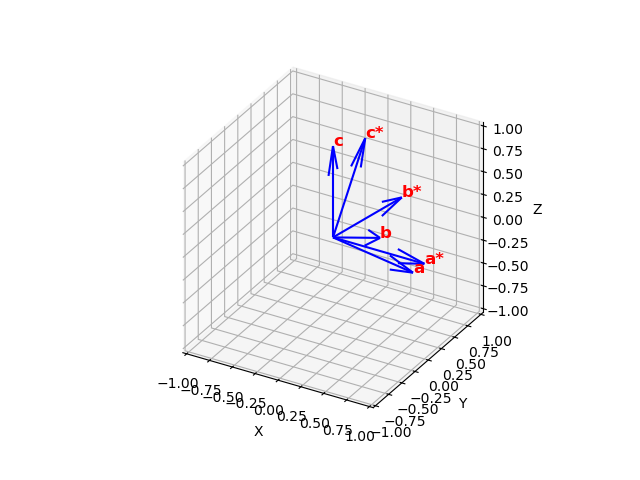

In [31]:
allvecs = np.vstack((a_cartesian, b_cartesian, c_cartesian, a_star_cartesian, b_star_cartesian, c_star_cartesian))
qpv(allvecs, labels=['a', 'b', 'c', 'a*', 'b*', 'c*'])

In [32]:
# we can compare this against VESTA

In [33]:
# import the CIF into VESTA for ICSD 131
# go to Utilities -> Standardization to transform into standardized
# then go to Edit -> Edit Data -> Phase to adjust the orientation
# This layer      |        Global coordinate system
# we want (h k l ) 1 0 0 || [u v w] 1 0 0 
# this is a* || x axis
# then [u v w] 0 0 1 || (h k l) 0 0 1
# then you can look along a, b, c, a*, b* and c*
# to confirm equality

In [ ]:
# also to look along certain orientations in (a, b, c)
# go to Objects -> Orientation
# projection vector - which direct space vector vector points towards you?
# upward vector - which reciprocal space vector goes upwards on the screen?

In [ ]:
# use mode project along [uvw]
# e.g if we want to look down [111] with [010] up:
# proj_vector [uvw] = [111] as desired
# upward_vector (hkl) = direct_to_reciprocal([010])
upward_vector_uvw = [0., 1.,0.]
upward_vector_hkl = direct_to_reciprocal(upward_vector_uvw, g.mt)
upward_vector_hkl

In [ ]:
# or with mode project along the normal to (h k l):
# if we want to look down [111] with [010] up:
# proj_vector (hkl) = direct_to_reciprocal([111])
# upward_vector [uvw] = [010] as desired
proj_vector_uvw = [1., 1.,1.]
proj_vector_hkl = direct_to_reciprocal(proj_vector_uvw, g.mt)
proj_vector_hkl